# To walk through clustering measurement for SV3 catalog
Author: Shadab Alam (salam@roe.ac.uk)

The aim is to show a step by step guide for clustering measurement and expected to be run on NERSC.

If you want to understand the basics of correlation function measurement\
then you can try these tutorials 
Binder to run things online: https://mybinder.org/v2/gl/shadaba%2Flss-handson/master
In the above link go to Tutorial folder. There are two tutorial along with solution. It will be good to just walk through them for general understanding of clustering.
Also, suggestion for improvement and clarifications in above tutorial will be appreciated.

A lot of decision needs to be made while making such measurement.\
This notebook tries to hide most of it from the user and as\
you understand and able to make your own measurement each of those decisions can be revisited.



In [1]:
#Some basic imports
from __future__ import print_function
#To make the plots inline otherwise it will make seperate figure
%matplotlib inline 
#for high resolution plot outputs
%config InlineBackend.figure_format = 'retina'

import pickle
import numpy as np
import pylab as pl
import fitsio as F
import time

from datetime import date

import os
import sys

In [3]:
#please do not change this directory unless you know what you are doing
#On pawna
main_code_dir='/user/shadab/Projects/CorrelationFunction/'

In [4]:
def make_dir(dirin):
    '''checks and creates a directory'''
    if(not os.path.isdir(dirin)):
        os.mkdir(dirin)
        print('created: ',dirin)
    else:
        print('Already exists: ',dirin)
        
    return

In [5]:
!ls /user/shadab/data/CDM_WDM_halos/XI

FITS_extended  Gcat  README.txt  scm_r1_z0z1  scm_r1_z0z1.tar.gz  wscm_r1_z0z1


## Output directory
Create directories to write the results and follow the directory tree carefully.
create a global directory (preferably in the scracth) but can be anywhere with user having write permission
define this directory as xidir below

In [6]:
#xidir='path to your output directory'
xidir='/user/shadab/data/CDM_WDM_halos/XI'
make_dir(xidir)

created:  /user/shadab/data/CDM_WDM_halos/XI


In [7]:
# This creates all the needed sub-direcotries so that code can work without hassles



def setup_directory_tree(xidir):
    '''This setups the directory tree'''
    global pcdir, wpdir,xi2ddir,xi02dir
    pcdir=xidir+'PairCount/'
    wpdir=xidir+'WP/'
    xi2ddir=xidir+'XI2D/'
    xi02dir=xidir+'XI02/'
    
    for td in [xidir,pcdir, wpdir,xi2ddir,xi02dir]:
        make_dir(td)

    return

setup_directory_tree(xidir)

Already exists:  /user/shadab/data/CDM_WDM_halos/XI
created:  /user/shadab/data/CDM_WDM_halos/XIPairCount/
created:  /user/shadab/data/CDM_WDM_halos/XIWP/
created:  /user/shadab/data/CDM_WDM_halos/XIXI2D/
created:  /user/shadab/data/CDM_WDM_halos/XIXI02/


## The following function is directly kept here so that user can easily see what is done and even modify


In [8]:
def tracer_program(tracer):
    if('BGS' in tracer or 'MWS' in tracer):
        return 'BRIGHT'
    else:
        return 'DARK'
    
def get_outroot(selection='TARGET',tracer='LRG',sky='N',wtag='w1',xitype='angular'):
    if(xitype=='angular'):
        outroot='%s%s_%s_%s_%s'%(pcdir,tracer_key(tracer),sky,selection,wtag)
    else:
        outroot='%s%s_%s_%s_%s_z1z2_'%(pcdir,tracer_key(tracer),sky,selection,wtag)
        
    return outroot

def config_file(config_dir,tracer,sky,xitype,wtag,zsel,tracer2=None):
    if(zsel is not None):
        ztag='_z1z2_%4.2f_%4.2f'%(zsel[0],zsel[1])
    else:
        ztag=''
    
    if(tracer2 is None):
        outfile='%s%s_%s_%s_%s%s.ini'%(config_dir,tracer,sky,xitype,wtag,ztag)
    else:
        outfile='%scross%sx%s_%s_%s_%s%s.ini'%(config_dir,tracer,tracer2,sky,xitype,wtag,ztag)
    
    return outfile

def prepare_config_file(tracer,sky,wtag='w1',xitype='angular',zsel=None,config_dir='config_desi_sv3/',
                       tracer2=None):
    
    '''prepares the configuration files
    provide tracer 2 and wtag2 if cross-correlation is needed'''
    
    if(zsel is not None):
        zsel_str='z1z2 = %4.2f, %4.2f'%(zsel[0],zsel[1])
    else:
        zsel_str=''
    
    outfile=config_file(config_dir,tracer,sky,xitype,wtag,zsel,tracer2=tracer2)
    
    program=tracer_program(tracer)
    with open(outfile,'w') as fout:
        if(tracer2 is None):
            fout.write('import_config1 = %sconfig_desi_glob/%s_global.ini\n'%(main_code_dir,xitype))
            fout.write('import_config2 = %sconfig_desi_glob/%s_catalog.ini\n'%(main_code_dir,program))
        else:
            fout.write('import_config1 = %sconfig_desi_glob/cross%s_global.ini\n'%(main_code_dir,xitype))
            fout.write('import_config2 = %sconfig_desi_glob/cross%s_catalog.ini\n'%(main_code_dir,program))

        fout.write(zsel_str)
            
        fout.write('\n\noutdir = %s\n\n'%(xidir))
        
        fout.write('\n\n#parameters for the this catalogue\n')
        fout.write('[sv3_desi]\n')
        fout.write('PROGRAM = %s\n'%program)
        fout.write('tracer = %s\n'%tracer)
        fout.write('sky = %s\n'%sky)
        fout.write('#This decides the weighting w1 is unit weight wsys is sys weight\n')
        fout.write('wtag = %s\n'%wtag)
        
        if(tracer2 is not None):
            fout.write('\n\n#parameters for the second catalogue\n')
            fout.write('[sv3_desi2]\n')
            fout.write('PROGRAM = %s\n'%program)
            fout.write('tracer = %s\n'%tracer2)
            fout.write('sky = %s\n'%sky)
            fout.write('#This decides the weighting w1 is unit weight wsys is sys weight\n')
            fout.write('wtag = %s\n'%wtag)   
               
    return outfile



### Now first lets create a temporary directory to write any configuration file for the clustering measurements
We will call this config_dir

In [10]:
config_dir='tmp_config_cdm_wdm/'
make_dir(config_dir)

created:  tmp_config_cdm_wdm/


### Lets make some choices as below, you can these as you like

In [11]:
tracer='LRG' #you can choose from LRG, ELG, QSO, BGS_ANY
sky='N'       #you can choose from N, S for north and South
xitype='wp'   #What statistic, you can choose from wp,xi02,xiwedge
zsel=[0.6,0.8]     #you can give a redshift range None mean no redshift selection will be applied



### Now create the config file as per your choices

In [12]:
conf_this=prepare_config_file(tracer,sky,wtag='wcompEdWsys',xitype=xitype,zsel=zsel,config_dir=config_dir,tracer2=None)
print('Created config_file: ',conf_this)

Created config_file:  tmp_config_cdm_wdm/LRG_N_wp_wcompEdWsys_z1z2_0.60_0.80.ini


In [13]:
# To measure the correlation function you need to now execute the following command
comm='python %sRunme_Correlation.py -config_file %s -selection CLUSTERING'%(main_code_dir,conf_this)
print('''Need to run this command it is fast generally fast, would recommend running this on debug node for exploring
      Or you can submit it to the queus using the next step
      To run interactively do following:
      salloc -N 1 -C haswell -t 00:30:00 --ntasks 1 --cpus-per-task=8 --qos shared --account desi
      ... wait for the job to be allocated if it takes too long then change -qos shared to --qos debug
      The shared queue is cheaper but you get allocated debug queue faster...
      source /project/projectdirs/desi/software/desi_environment.sh master
      ... once the resource is allocated load the desi environment using above 
      and then run the python command
      ''')

print(comm)

Need to run this command it is fast generally fast, would recommend running this on debug node for exploring
      Or you can submit it to the queus using the next step
      To run interactively do following:
      salloc -N 1 -C haswell -t 00:30:00 --ntasks 1 --cpus-per-task=8 --qos shared --account desi
      ... wait for the job to be allocated if it takes too long then change -qos shared to --qos debug
      The shared queue is cheaper but you get allocated debug queue faster...
      source /project/projectdirs/desi/software/desi_environment.sh master
      ... once the resource is allocated load the desi environment using above 
      and then run the python command
      
python /user/shadab/Projects/CorrelationFunction/Runme_Correlation.py -config_file tmp_config_cdm_wdm/LRG_N_wp_wcompEdWsys_z1z2_0.60_0.80.ini -selection CLUSTERING


In [11]:
def slurm_script_shared(outfile,comm,ncpu=4,time=None):
    with open(outfile,'w') as fout:
        fout.write('#!/bin/bash\n')
        fout.write('#SBATCH --qos=shared\n')
        fout.write('#SBATCH --constraint=haswell\n')
        if(time is None):
            time='01:00:00'
            
        fout.write('#SBATCH --time=%s\n'%time)
        
        fout.write('#SBATCH --nodes=1\n')
        fout.write('#SBATCH --ntasks=1\n')
        fout.write('#SBATCH --cpus-per-task=%s\n'%ncpu)
        
        fout.write('\nsource /project/projectdirs/desi/software/desi_environment.sh master \n')
        
        for tcomm in comm:
            fout.write('srun --cpu-bind=cores %s \n'%tcomm)
        
    print('sbatch %s'%outfile)
    
    return

outfile='slurm-job-%s-%s-%s.sh'%(tracer,sky,xitype)
slurm_script_shared(outfile,[comm],ncpu=8,time=2)


sbatch slurm-job-LRG-N-wp.sh


### Once the above code has finished running then it will produce a clustering measurement with jacknife covariance which is writes the file path to
It always produce a 2d correlation function plot written under xi2ddir \
for xitype=wp it will produce a wp file written under wpdir as shown below\

The file format is specified in the header and these are simple ascii files.\
Generally the format is \
index=0: first column is r, \
index=1: second column if clustering measurement (wp in this case) , this is mean of jackknife\
index=2: third column will be the diagonal error estimates\
index=3: fourth column is the clustering from the full sample\
index=4-n: This are individual jackknife realizations\

In [12]:
wpfile=wpdir+'LRG_N_CLUSTERING_wcompEdWsys_z1z2_0.6-0.8-wp-logrp-pi-NJN-120.txt'

Following example shows how to load and plot the wp results

Text(0, 0.5, '$w_p$')

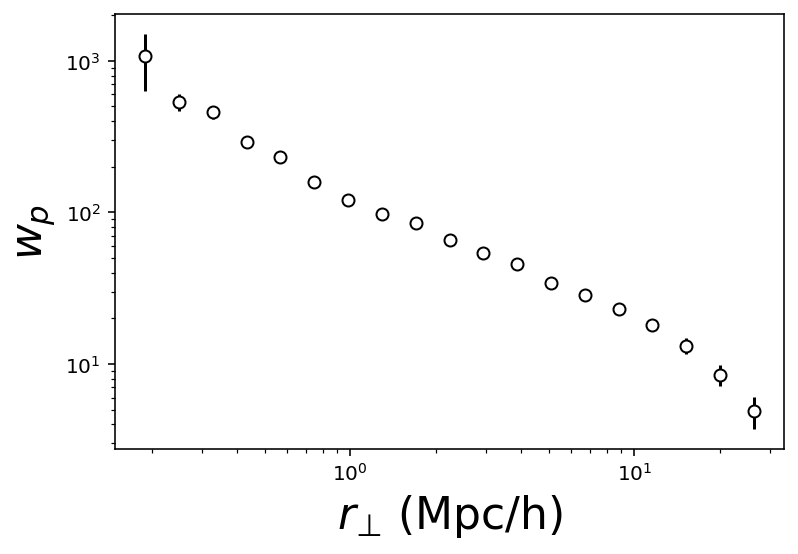

In [14]:
wpdata=np.loadtxt(wpfile)

pl.errorbar(wpdata[:,0],wpdata[:,1],wpdata[:,2],fmt='o',mfc='w',color='k')
pl.xscale('log')
pl.yscale('log')

pl.xlabel(r'$r_\bot$ (Mpc/h)',fontsize=22)
pl.ylabel(r'$w_p$',fontsize=22)